In [2]:
%matplotlib inline 

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.utils import plot_model

import sys
sys.path.insert(0, '../api_tutorials')
from bqsr_cnn import parse_args, read_to_bqsr_tensor, bqsr_get_metric_dict, bqsr_bed_file_to_dict, BQSR_LABELS
from bqsr_cnn import bqsr_get_train_valid_test_paths_all, bqsr_label_tensors_generator, OQ_TENSOR_NAME, BQSR_TENSOR_NAME
from bqsr_cnn import INPUT_SYMBOLS
from recal_utils import tensor_to_quality_array, KL_divergence, get_next_batch

In [4]:
sys.argv = ['bqsr_cnn']
args = parse_args()

Arguments are Namespace(activation='relu', activity_weight=1.0, annotation_set='_', annotations=[], bam_file=None, base_quality_mode='phot', batch_size=32, bed_file=None, channels_last=False, chrom=None, conv_batch_normalize=False, conv_dropout=0.0, conv_layers=[128, 96, 64, 48], conv_widths=[5, 5, 5, 5], data_dir=None, downsample_perfect_reads=0.0, end_pos=0, epochs=25, fc_batch_normalize=False, fc_dropout=0.0, fc_initializer='glorot_normal', fc_layers=[32], fps=1, id='no_id', ignore_vcf=None, input_symbol_set='dna_annotations', input_symbols={'A': 0, 'C': 1, 'G': 2, 'T': 3, 'pair': 4, 'cycle': 5, 'mq': 6}, inspect_model=False, inspect_show_labels=False, iterations=5, jitter=0.0, kernel_initializer='glorot_normal', l1=0.0, l2=0.0, label_smoothing=0.0, label_weights=[], labels={'GOOD_BASE': 0, 'BAD_BASE': 1}, learning_rate=0.01, map_input_to_logspace=False, max_pools=[], maxfun=9, mode=None, model=None, out='recalibrated.bam', output_dir='./weights/', padding='same', patience=4, random

In [6]:
# model_id = 'keep-10percent-of-perfect-reads'
# model_id = 'use-oq'
# model_id = "weighted-cross-entropy"

# args.data_dir = '/home/tsato/data/tensors/10-25-2018/'
# args.data_dir = '/home/tsato/data/tensors/oq/'

# args.data_dir='/home/tsato/data/tensors/with-bqsr-include-q2/'
# args.data_dir = '/home/tsato/data/tensors/remove-all-error-reads-mini/'

model_id = "no-weighting"
args.data_dir = '/home/tsato/data/tensors/downsample-0.999/'

best = False
if best:
    model_id = "remove-q2-take2" # BEST MODLE THUS FAR
    args.data_dir = '/home/tsato/data/tensors/remove-q2/'
    args.data_dir = '/home/tsato/data/tensors/downsample-0.999/'
    args.label_weights = [1.0, 75.0]
    args.input_symbols = INPUT_SYMBOLS['dna_annotations']
else:
    model_id = "heavy-downsample-with-w10"
    args.data_dir = '/home/tsato/data/tensors/downsample-0.999/'
    args.label_weights = [1.0, 75.0]

    model_id = "old-new-params"
    args.data_dir = '/home/tsato/data/tensors/downsample-0.999/'

    model_id = "dna-only-patient"
    args.data_dir = '/home/tsato/data/tensors/downsample-0.999/'
    args.data_dir = '/home/tsato/data/tensors/ds-0.999-remove-indels-mini/'
    model_id = "c"
    model_id = "1"
    model_id = "7-layer"
    args.input_symbols = INPUT_SYMBOLS['dna_annotations']
    args.input_symbols = INPUT_SYMBOLS['dna']


model_path = '/home/tsato/model/' + model_id + "/" + model_id + ".hd5"

map_input_to_logspace = True
label_weights = [1.0, 1.0]
model = load_model(model_path, custom_objects=bqsr_get_metric_dict(BQSR_LABELS, label_weights))
model.summary()
plot_model(model, to_file='/home/tsato/model/%s/%s.png' % (model_id, model_id), show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
oq (InputLayer)              (None, 151, 4)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 151, 128)          2688      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 151, 128)          82048     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 151, 128)          245888    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 151, 128)          573568    
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 151, 128)          245888    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 151, 128)          82048     
__________

In [20]:
print('/home/tsato/model/%s/%s.png' % (model_id, model_id))

/home/tsato/model/7-layer/7-layer.png


In [8]:
train_paths, valid_paths, test_paths = bqsr_get_train_valid_test_paths_all(args.data_dir)

generate_train = bqsr_label_tensors_generator(args, train_paths, include_bqsr=True)
generate_valid = bqsr_label_tensors_generator(args, valid_paths, include_bqsr=True)
generate_test = bqsr_label_tensors_generator(args, test_paths, include_bqsr=True)



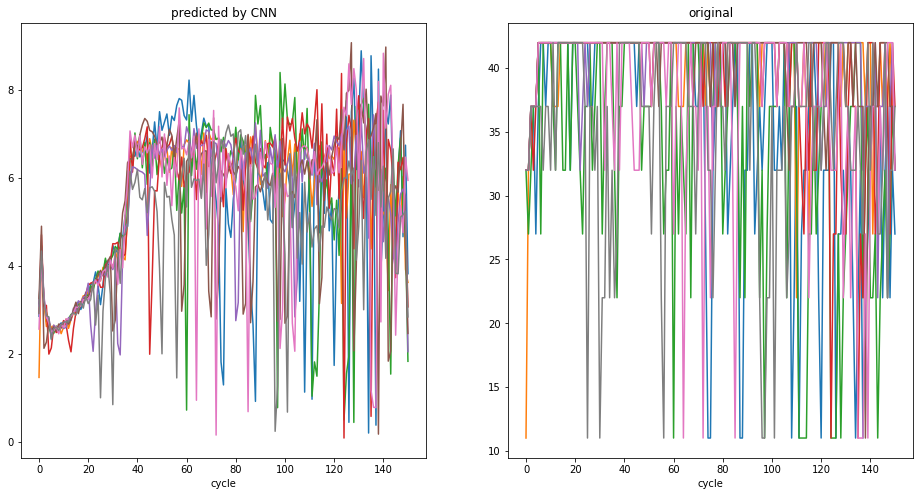

In [10]:
pred_qscores, orig_qscores, bqsr, label = get_next_batch(model, generate_test, args)
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False)
fig.set_size_inches(16, 8)
ax1.set_title("predicted by CNN")
ax1.set_xlabel("cycle")
# ax1.axhline(y = -10*np.log10(0.5))
ax1.plot(np.arange(args.window_size), pred_qscores[:8].T)
ax2.set_title("original")
ax2.set_xlabel("cycle")
ax2.plot(np.arange(args.window_size), orig_qscores[:8].T)
plt.show() # suppress the lines

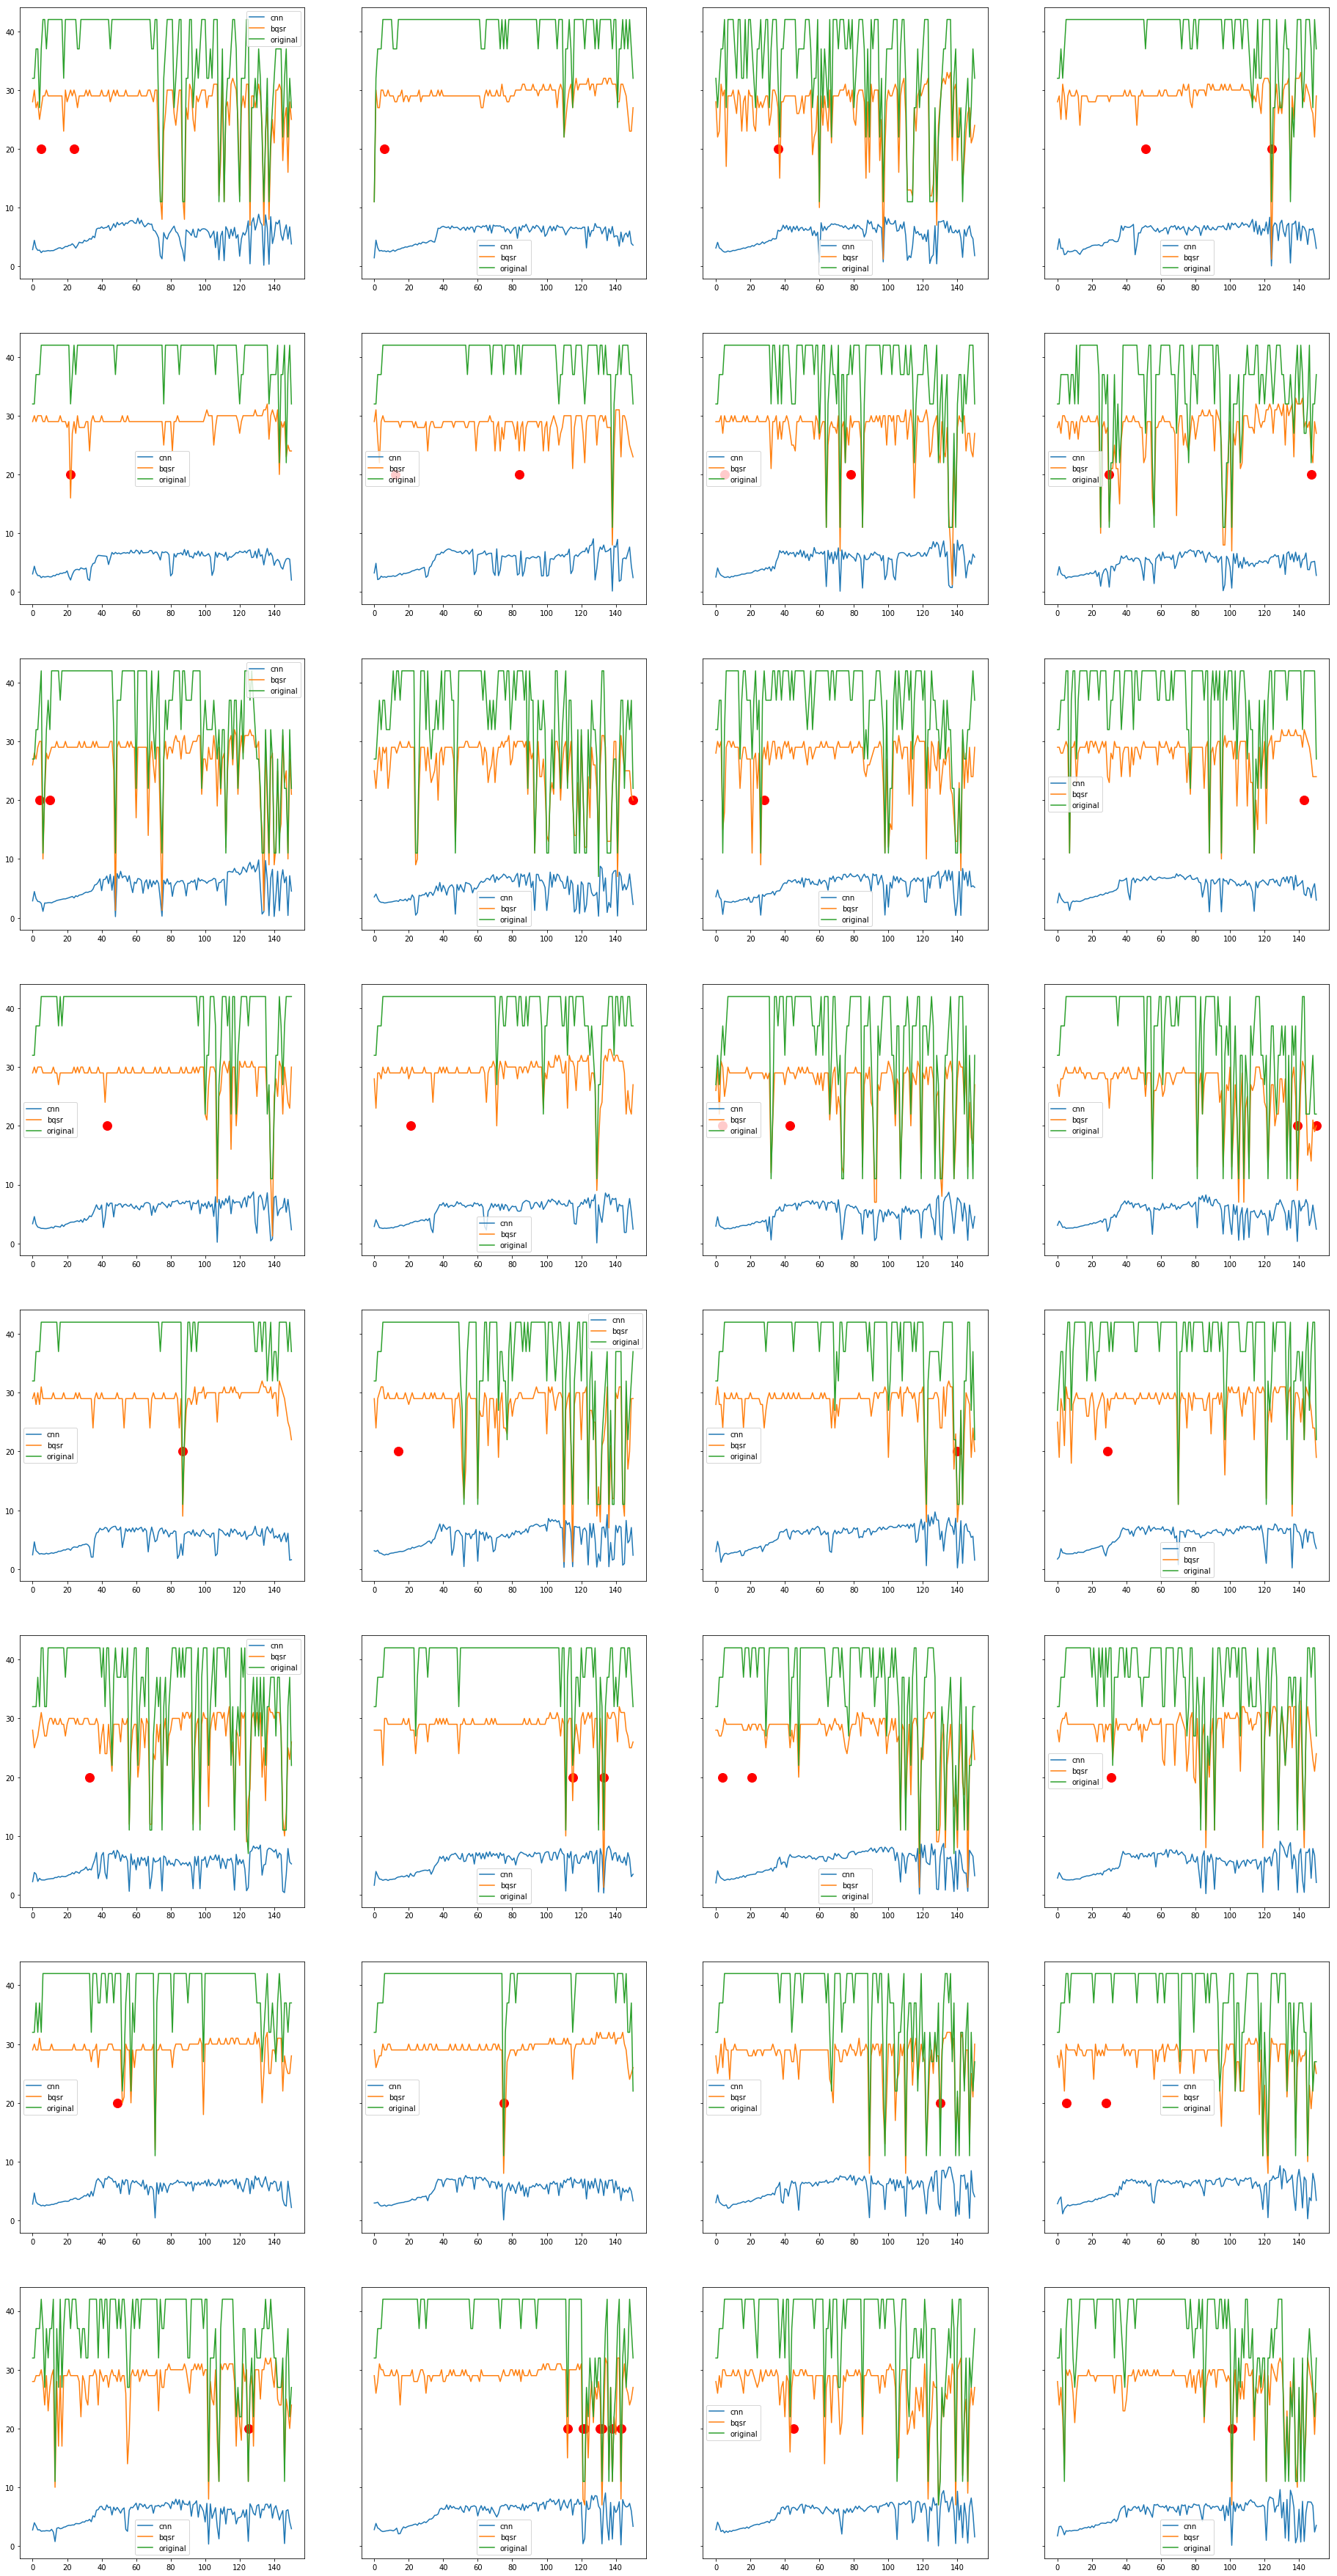

In [11]:
nrow,ncol = 8,4
fig, ax = plt.subplots(nrow, ncol, sharey=True)
fig.set_size_inches(ncol*8, nrow*8)

for i in np.arange(nrow):
    for j in np.arange(ncol):
        sample_idx = i*ncol+j
        
        mismatches = np.nonzero(label[sample_idx, :, BQSR_LABELS['BAD_BASE']])
        ax[i][j].plot(mismatches, 20*np.ones(len(mismatches)), 'ro', markersize=12)
        ax[i][j].plot(np.arange(args.window_size), pred_qscores[sample_idx], label="cnn")
        ax[i][j].plot(np.arange(args.window_size), -10*np.log10(1-np.max(bqsr[sample_idx], axis=1)), label="bqsr")
        ax[i][j].plot(np.arange(args.window_size), orig_qscores[sample_idx], label="original")
        ax[i][j].legend()

In [12]:
# plot the histograms of good vs bad bases
max_quality = 50
num_batches = 1000

current_match_idx = 0
current_mismatch_idx = 0
init_size = 32*151 # size of a single batch

match_qs = np.zeros(0)
mismatch_qs = np.zeros(0)
match_orig_qs = np.zeros(0)
mismatch_orig_qs = np.zeros(0)

for i in np.arange(num_batches):
    pred_qscores, orig_qscores, bqsr, label = get_next_batch(model, generate_test, args)
    
    pred = pred_qscores[:,:,np.newaxis] * label
    orig = orig_qscores[:,:,np.newaxis] * label

    match_tmp = pred[:,:,args.labels['GOOD_BASE']].flatten()
    match_qs = np.concatenate((match_qs, match_tmp[match_tmp != 0])) # remove entries that are zero
    
    mismatch_tmp = pred[:,:,args.labels['BAD_BASE']].flatten()
    mismatch_qs = np.concatenate((mismatch_qs, mismatch_tmp[mismatch_tmp != 0]))
    
    match_orig_tmp = orig[:,:,args.labels['GOOD_BASE']].flatten()
    match_orig_qs = np.concatenate((match_orig_qs, match_orig_tmp[match_orig_tmp != 0]))
    mismatch_orig_tmp = orig[:,:,args.labels['BAD_BASE']].flatten()
    mismatch_orig_qs = np.concatenate((mismatch_orig_tmp, mismatch_orig_tmp[mismatch_orig_tmp != 0]))

# TODO: must investigate why sometimes labels don't add up to 32*151...
# assert np.prod(label.shape)*num_batches == match_qs.shape[0] + mismatch_qs.shape[0]
print('mean of match bq = ' + str(np.mean(match_qs)))
print('std of match bq = ' + str(np.std(match_qs)))
print('mean of mismatch bq = ' + str(np.mean(mismatch_qs)))
print('std of mismatch bq = ' + str(np.std(mismatch_qs)))

mean of match bq = 5.4390501148
std of match bq = 1.77159368218
mean of mismatch bq = 3.06582464795
std of mismatch bq = 2.35602287065


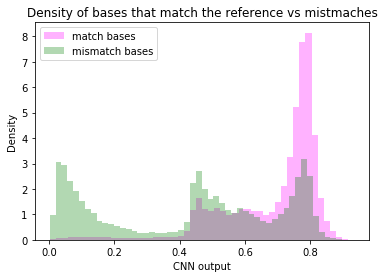

In [23]:
plt.hist(1-np.power(10, (-match_qs/10.0)), bins=max_quality, color="magenta", alpha=0.3, density=True, label="match bases")
plt.hist(1-np.power(10, (-mismatch_qs/10.0)), bins=max_quality, color="green", alpha=0.3, density=True, label="mismatch bases")
plt.legend()
plt.ylabel("Density")
plt.xlabel("CNN output")
plt.title("Density of bases that match the reference vs mistmaches")
plt.savefig(fname = "/home/tsato/poster/histogram.png")

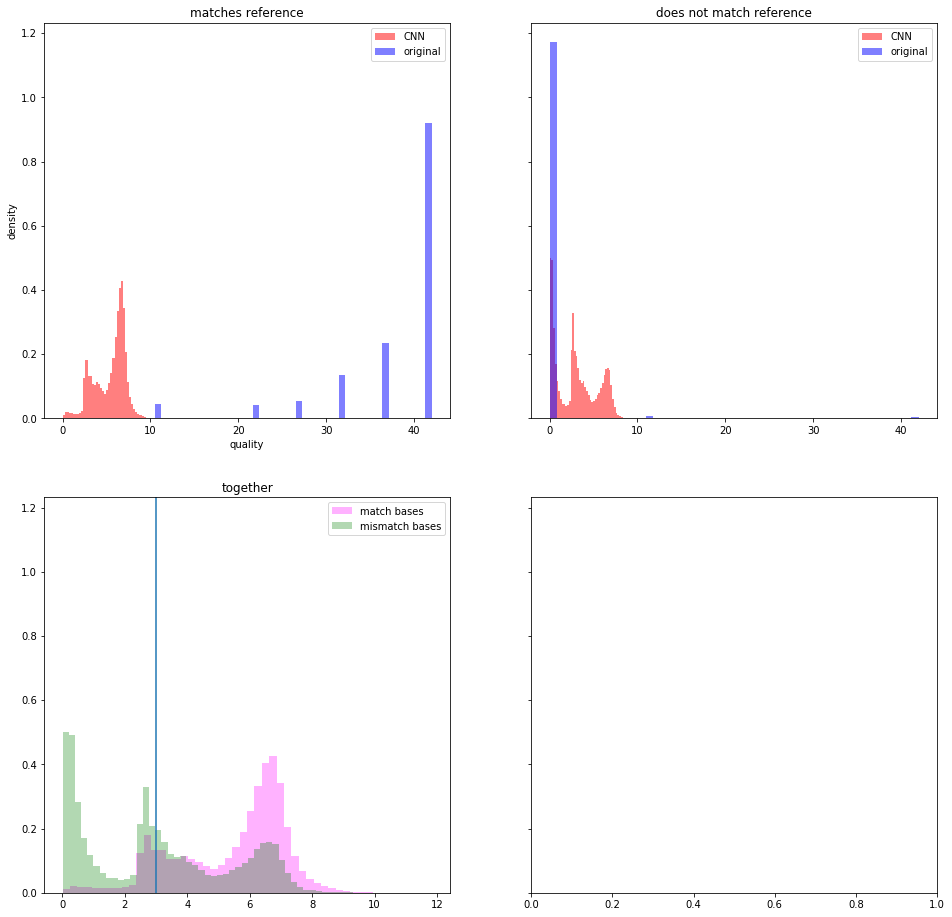

In [8]:
# normalize and plot the differences before and after the recalibration
fig, (ax_r1, ax_r2) = plt.subplots(nrows=2,ncols=2,sharex=False, sharey=True)
fig.set_size_inches(16, 16)

ax1=ax_r1[0]
ax1.hist(match_qs, bins=max_quality, color="red", alpha=0.5, density=True, label="CNN")
ax1.hist(match_orig_qs, bins=max_quality, color="blue", alpha=0.5, density=True, label="original")
ax1.legend()
ax1.set_title("matches reference")
ax1.set_ylabel("density")
ax1.set_xlabel("quality")

ax2=ax_r1[1]
ax2.hist(mismatch_qs, bins=max_quality, color="red", alpha=0.5, density=True, label="CNN")
ax2.hist(mismatch_orig_qs, bins=max_quality, color="blue", alpha=0.5, density=True, label="original")
ax2.legend()
ax2.set_title("does not match reference")

ax3=ax_r2[0]
ax3.hist(match_qs, bins=max_quality, color="magenta", alpha=0.3, density=True, label="match bases")
ax3.hist(mismatch_qs, bins=max_quality, color="green", alpha=0.3, density=True, label="mismatch bases")
ax3.legend()
ax3.axvline(x=-10*np.log10(0.5))
ax3.set_title("together")

ax4=ax_r2[1]


plt.show()

#### Read Corrections
Given the array of scores from the model, we must first convert them to quality scores. Here are some ways in which we can do this:

* Sort the bases by quality in increasing order. Divide them into however many bins, and compute the empirical quality within each bin, then round to the nearest integer. Call this f : R -> Z.
* Set the quality bins (e.g. 10, 20, 30, 40) and find the thresholds adaptively. I find that we usually run out of good bases towards the end such that we cannot find a threshold for Q20.

For both these cases, the thresholds will be set with the training set, and evaluation metrics taken with the test set.

#### Evaluation Metrics

Once we have the scores we can evaluate its performance. The metrics include

* KL divergence between the match bases vs the mismatch bases. The greater this number is, the better.
* For each bin, compare the empirical quality to the recalibrated quality, and compare the distance between BQSR and CNN.

In [24]:
# BINNING: 
num_batches = 300
batch_size = 32
read_length = 151
num_bins = 100

prediction = np.zeros((num_batches, batch_size, read_length))
bqsr = np.zeros((num_batches, batch_size, read_length))
labels = np.zeros_like(prediction)
for i in np.arange(num_batches):
    pred_qscores, orig_qscores, bqsr_scores, label = get_next_batch(model, generate_test, args)
    prediction[i] = pred_qscores
    # TODO: use the API
    bqsr[i] = -10*np.log10(1-np.max(bqsr_scores, axis=2))
    labels[i] = np.argmax(label, axis=2)
    
sorted_idx = np.argsort(prediction.flatten())
truth = labels.flatten()
sorted_truth = truth[sorted_idx]
sorted_pred = prediction.flatten()[sorted_idx]
sorted_bqsr = bqsr.flatten([sorted_idx])



Generator looped over all  40408  tensors, now shuffle them. Last tensor was: /home/tsato/data/tensors/ds-0.999-remove-indels-mini/test/NA12878_nist_na12878_minimal-HK35M.71_28472946.hd5


bqsr_cnn:21: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead


In [25]:
i=0
print(len(sorted_truth))
print(num_bins)
# np.sum(sorted_truth[i*bin_size : np.min((i+1)*bin_size, len(sorted_truth))])

1449600
100


bin size is 14496


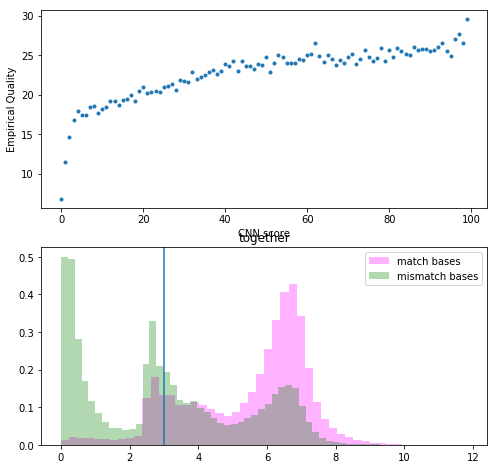

In [27]:
# partition the indices evenly
bin_size = int(len(sorted_pred)/num_bins)
print('bin size is ' + str(bin_size))

emp_p = np.zeros(num_bins)
cutoff = np.zeros(num_bins) # stores the right end of the bins

bases_used=0
for i in np.arange(num_bins):
    emp_p[i] = np.sum(sorted_truth[i*bin_size : (i+1)*bin_size])/bin_size
    cutoff[i] = sorted_pred[(i+1)*bin_size-1]

emp_q = -10*np.log10(emp_p)

fig, (ax1, ax2) = plt.subplots(nrows=2,ncols=1,sharex=False, sharey=False)
fig.set_size_inches(8, 8)

ax1.plot(np.arange(num_bins), emp_q, '.')
ax1.set_xlabel("CNN score")
ax1.set_ylabel("Empirical Quality")

ax2.hist(match_qs, bins=max_quality, color="magenta", alpha=0.3, density=True, label="match bases")
ax2.hist(mismatch_qs, bins=max_quality, color="green", alpha=0.3, density=True, label="mismatch bases")
ax2.legend()
ax2.axvline(x=-10*np.log10(0.5))
ax2.set_title("together")

def f(cutoff, emp_q, s):
    ''' maps the scores from the segmentation CNN to quality
        s : a double, which is the score from the segmentation CNN
    '''
    if s >= cutoff[-1]:
        return np.round(emp_q[-1])
    idx = np.where(cutoff > s)[0][0] - 1
    return np.round(emp_q[idx])
 

In [28]:
num_batches = 300

bqsr_q = np.zeros((num_batches, args.batch_size, args.window_size))
cnn_q = np.zeros_like(bqsr_q)
labels = np.zeros((num_batches, args.batch_size, args.window_size))

for k in np.arange(num_batches):
    pred_scores, orig_qscores, bqsr_tensor, label = get_next_batch(model, generate_test, args)
    bqsr = -10*np.log10(1-np.max(bqsr_tensor, axis=2))
    m,n = pred_scores.shape
    pred = np.zeros_like(pred_scores)
    for i in np.arange(m):
        for j in np.arange(n):
            pred[i,j] = f(cutoff, emp_q, pred_scores[i,j])
    cnn_q[k] = pred
    bqsr_q[k] = bqsr
    labels[k] = np.argmax(label, axis=2)
    
bqsr_q = bqsr_q.flatten()
cnn_q = cnn_q.flatten()
labels = labels.flatten()

bqsr_cnn:17: RuntimeWarning: divide by zero encountered in log10
bqsr_cnn:22: RuntimeWarning: divide by zero encountered in log10


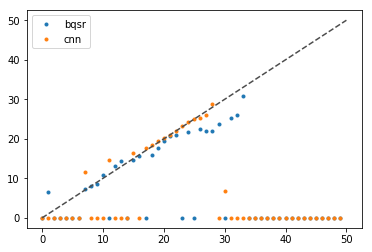

In [29]:
max_q = 50
cnn_bad_bases = np.zeros(max_q)
cnn_total = np.zeros(max_q)
bqsr_bad_bases = np.zeros(max_q)
bqsr_total = np.zeros(max_q)

for i in np.arange(len(cnn_q)):
    cnn_qual = int(cnn_q[i])
    bqsr_qual = int(bqsr_q[i])
    
    if labels[i] == 1: # 'BAD BASE'
        cnn_bad_bases[cnn_qual] += 1
        bqsr_bad_bases[bqsr_qual] += 1
    cnn_total[cnn_qual] += 1
    bqsr_total[bqsr_qual] += 1 
cnn_emp_p = np.divide(cnn_bad_bases, cnn_total, out=np.zeros_like(cnn_total), where=cnn_total != 0)
cnn_emp_q = -10*np.log10(cnn_emp_p)
from numpy import inf # TODO: use masked array
cnn_emp_q[cnn_emp_q == inf] = 0

bqsr_emp_p = np.divide(bqsr_bad_bases, bqsr_total, out=np.zeros_like(bqsr_total), where=bqsr_total != 0)
bqsr_emp_q = -10*np.log10(bqsr_emp_p)
bqsr_emp_q[bqsr_emp_q == inf] = 0

plt.plot(np.arange(max_q), bqsr_emp_q, '.', label="bqsr")
plt.plot(np.arange(max_q), cnn_emp_q, '.', label="cnn")
plt.plot([0, max_q], [0, max_q], ls="--", c=".3")
plt.legend()
plt.show()

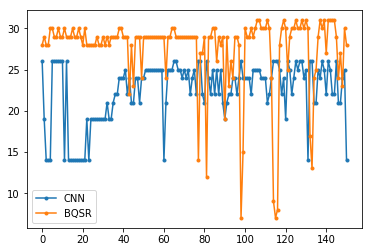

(32, 151, 4)


In [14]:
plt.plot(np.arange(151), pred.T[:,0], '.-', label="CNN")
plt.plot(np.arange(151), bqsr[0,:], '.-', label="BQSR")
plt.legend()
plt.show()
print(bqsr_scores.shape)

# It would be nice to show the reference bases on the x-axis!

In [15]:
pred_scores, orig_qscores, bqsr_scores, label = get_next_batch(model, generate_test, args)

In [16]:
### on hold: adaptive partitioning scheme ###
# cumsum = np.cumsum(sorted_truth)
# cum_error_rate = cumsum / (np.arange(cumsum.shape[0])+1)

# cumsum = np.cumsum(sorted_truth)
# cum_error_rate = cumsum / (np.arange(cumsum.shape[0])+1)

# # finds the index of first element that's greater than 0, computed to avoid the pathological case where the cumulative sum < 1
# buffer=np.argmax(cumsum > 0)
# q10_cutoff = np.argmax((cum_error_rate < 1e-1)[buffer:]) + buffer # argmax finds the first occurence of True
# print('using the buffer of %d, the Q10 cutoff is %d' % (buffer,q10_cutoff))


# q20_cum_sum = np.cumsum(sorted_truth[q10_cutoff:])
# buffer=np.argmax(q20_cum_sum > 0)
# q20_cum_error_rate = q20_cum_sum /(np.arange(q20_cum_sum.shape[0])+1)
# q20_cutoff = np.argmax(q20_cum_error_rate[buffer:] < 1e-2) + buffer + q10_cutoff
# print('using the buffer of %d, the Q20 cutoff is %d' % (buffer, q20_cutoff))

# q30_cum_sum = np.cumsum(sorted_truth[q20_cutoff:])
# buffer=np.argmax(q30_cum_sum > 0)
# q30_cum_error_rate = q30_cum_sum /(np.arange(q30_cum_sum.shape[0])+1)
# cutoff = np.argmax(q30_cum_error_rate[buffer:] < 1e-3)
# if (cutoff == 0):
#     print("cutoff not found - rest of the qualities will be set empirically")
#     quality = q30_cum_sum[-1]/q30_cum_sum.shape[0]
#     print('the last bin has the quality %d' % (-10*np.log10(quality)))
# else: 
#     q30_cutoff = cutoff + buffer + q20_cutoff

# plt.figure(figsize=(16,8))
# plt.subplot(1,2,1)
# plt.plot(np.arange(cumsum.shape[0]), cumsum, '.')
# plt.xlabel("sorted array index")
# plt.ylabel("cumulative sum of mismatch bases")
# plt.axvline(x = q10_cutoff, color='red')
# plt.axvline(x = q20_cutoff)
# plt.axvline(x = q30_cutoff)

# plt.subplot(1,2,2)
# plt.plot(np.arange(cumsum.shape[0]), cum_error_rate, '.')
# plt.axvline(x = q10_cutoff, color='red')
# plt.axvline(x = q20_cutoff)
# plt.axvline(x = q30_cutoff)